<a href="https://colab.research.google.com/github/tvauss/TV1_ODIR19/blob/main/IV_Classification_Model_Workflow_and_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning Model - Workflow and Results**

This project was a collaborative project involving 2 other persons (see github pages here: https://github.com/okbabent).

In order to set a classification model, we based our worked on transfer learning which re-used pre-trained models to apply it to our data.

In order to simplify our work, all the results obtained using this method are not shown here but are discussed at the end of this notebook.

However, the general workflow we used is described below.

<b>1- Mount Google Drive files to access data: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive' )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<b>2- Import necessary packages and modules:

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

import json
import codecs
import os
import pickle

# Import models:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.applications.resnet_v2 import ResNet50V2

# Other imports used during this project: 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, ConvLSTM2D, Conv3D, MaxPooling2D, Dropout, MaxPooling3D
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import plot_model
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

<b>3- Set the constants related to the size of the image for our model:

In [ ]:
WIDTH = 224
HEIGHT = 224

<b>4- Create a function to load our data:</b>

This will load the numpy files created when converting the processed images into np files.
<br><i>(see
TV1_ODIR19/III-Image_processing/IIIc- Conversion to np files.ipynb)</i>

In [ ]:
def load_data(file_x, file_y):

    x = np.load('/content/drive/MyDrive/Colab Notebooks/Aug/'+file_x)
    y = np.load('/content/drive/MyDrive/Colab Notebooks/Aug/'+file_y)
    
    ohe = OneHotEncoder()
    y = ohe.fit_transform(y.reshape(-1,1)).toarray()
     
    return (x , y)

<b>5- Set the model: </b>

Below we create a class called 'TransferLearningNN' allowing us to instantiate different pre-trained models of interest, among which: 'Xception', 'VGG16', 'VGG19', 'ResNet50', 'InceptionV3', 'InceptionResNetV2'.

In [ ]:
class TransferLearningNN:
    def __init__(self, model_type, output_map, nb_neurons, nb_layers, dropout):
        self.training_history = None
        self.model_type = model_type
        self.output_map = output_map
        #self.plotter = Plotter(['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others']) #, model_type=self.model_type)
        self.y_pred = None
        self.X_test = None
        self.y_test = None
        self.validation_data = None
        self.defined_metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc')]
        self._init_model(nb_neurons=nb_neurons, nb_layers=nb_layers, dropout_rate=dropout)

    # Initiate model and add final layer 
    def _init_model(self, nb_layers=1, nb_neurons=1000, dropout_rate=0.5, activation='relu'):
        base_model = self._get_base_model()
        for layer in base_model.layers:
            layer.trainable = True
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        if nb_layers<1 :
            nb_layers = 1
        for i_layer in range(nb_layers):
            div = 2**i_layer
            if (nb_neurons // (div))<128:
                break
            x = Dense(nb_neurons//(div), activation=activation)(x)
            if dropout_rate!=0.0:
                x = Dropout(rate=dropout_rate)(x)
        predictions = Dense(8, activation='softmax')(x)
        full_model = Model(inputs=base_model.input, outputs=predictions)
        self.model = full_model

    # Choose the model of interest:  
    def _get_base_model(self):
        if self.model_type == 'inception_v3':
            return InceptionV3(weights='imagenet', include_top=False,input_shape=(HEIGHT, WIDTH, 3))
        elif self.model_type == 'xception':
            return Xception(weights='imagenet', include_top=False,input_shape=(HEIGHT, WIDTH, 3))
        elif self.model_type == 'vgg16':
            return VGG16(weights='imagenet', include_top=False,input_shape=(HEIGHT, WIDTH, 3))
        elif self.model_type == 'vgg19':
            return VGG19(weights='imagenet', include_top=False,input_shape=(HEIGHT, WIDTH, 3))
        elif self.model_type == 'resnet50':
            return ResNet50(weights='imagenet', include_top=False,input_shape=(HEIGHT, WIDTH, 3))
        else:
            raise ValueError('Cannot find base model %s' % self.model_type)

    # Define function to finally fit the model 
    # (with X being the image-related numpy files and y being the labels from our dataset):
    def fit(self, X_train, y_train, X_test, y_test, epochs=50):
        self.X_test = X_test
        self.y_test = y_test
        # Set optimizers of interest
        optimize_adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        optimize_sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
        # Compile model:
        self.model.compile(optimizer=optimize_sgd, loss='categorical_crossentropy', metrics=self.defined_metrics)
        # Model fitting:
        self.training_history = self.model.fit(x=X_train, y=y_train, epochs=epochs, verbose=1,
                                               callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)],
                                               shuffle=True, validation_data=(X_test, y_test))
        # Sample test prediction: 
        self.y_pred = self.model.predict(x=X_test)

    # Define a function to display the metrics from the test dataset: 
    def print_evaluation(self):
        results = self.model.evaluate(self.X_test, self.y_test, verbose=2)
        for name, value in zip(self.model.metrics_names, results):
            print(name, ': ', value)
        y_test_flat = self.y_test.flatten()
        y_pred_flat = self.y_pred.flatten()
        kappa = metrics.cohen_kappa_score(y_test_flat, y_pred_flat > 0.5)
        f1 = metrics.f1_score(y_test_flat, y_pred_flat > 0.5, average='micro')
        print('kappa: ', kappa)
        print('F1_score: ', f1)

<b>6- Load the data:</b>

The data correspond to the numpy files previously created. 

<i>NB: Since 2 different sets of X_train and y_train data were previously created, np.vstack was used to 'concatenate' both X and y sets of 3-D arrays back together.</i>



In [ ]:
(X_train_1, y_train_1)= load_data(file_x='X_Aug_train_1.npy', file_y='y_Aug_train_1.npy')
(X_train_2, y_train_2)= load_data(file_x='X_Aug_train_2.npy', file_y='y_Aug_train_2.npy')
(X_test, y_test)= load_data(file_x='X_Aug_test.npy', file_y='y_Aug_test.npy')
# Compline X_train and y_train files
X_train = np.vstack((X_train_1,X_train_2))
y_train = np.vstack((y_train_1, y_train_2))

<b>7- Initiate the model:

In [ ]:
model = TransferLearningNN(model_type='resnet50', output_map=[0,1,2,3,4,5,6,7], nb_neurons=1024, nb_layers = 1, dropout = 0.4)

<b>8- Save and show the model summary <i>(Optional)</i> : 

In [ ]:
#Save the model:
model.model.save('/content/drive/MyDrive/Colab Notebooks/model_17_10_resnet50_a.h5')

#Show the model:

#OPTION1: 
#from tensorflow.keras.utils import plot_model
#plot_model(model.model)

#OPTION2=
from keras.models import load_model
sum_model = load_model('/content/drive/MyDrive/Colab Notebooks/model_17_10_resnet50_a.h5')
sum_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

<b>9- Pre-process Numpy files:</b> 

Here the Numpy array encoding the patient's eye-fundi are pre-processed in order to make it suitable to the format required by our models.

In [ ]:
from keras.applications.resnet import preprocess_input
X_train = preprocess_input(X_train)
X_test =  preprocess_input(X_test)

<b>10- Model fitting:

In [ ]:
history=model.fit(X_train, y_train, X_test, y_test, epochs = 40)

Epoch 1/40
617/617 [==============================] - 50s 73ms/step - loss: 1.0866 - accuracy: 0.9174 - precision: 0.8368 - recall: 0.4218 - auc: 0.9117 - val_loss: 0.8141 - val_accuracy: 0.9308 - val_precision: 0.8584 - val_recall: 0.5343 - val_auc: 0.9518 - lr: 0.0010
Epoch 2/40
617/617 [==============================] - 38s 62ms/step - loss: 0.6251 - accuracy: 0.9443 - precision: 0.8587 - recall: 0.6634 - auc: 0.9715 - val_loss: 0.7058 - val_accuracy: 0.9358 - val_precision: 0.7959 - val_recall: 0.6541 - val_auc: 0.9645 - lr: 0.0010
Epoch 3/40
617/617 [==============================] - 38s 62ms/step - loss: 0.4485 - accuracy: 0.9570 - precision: 0.8765 - recall: 0.7632 - auc: 0.9849 - val_loss: 0.6161 - val_accuracy: 0.9450 - val_precision: 0.8204 - val_recall: 0.7171 - val_auc: 0.9718 - lr: 0.0010
Epoch 4/40
617/617 [==============================] - 38s 62ms/step - loss: 0.3432 - accuracy: 0.9672 - precision: 0.8974 - recall: 0.8332 - auc: 0.9910 - val_loss: 0.5951 - val_accuracy:

<b>11- Model evaluation:</b>

When looking at the metrics below, the accuracy seems to indicate that our model perfoms pretty well (94.6%). 

However, the accuracy is not the metric of choice here as our dataset originally had a class imbalance for which the precision (how well the model correctly makes a prediction) and the recall (how often it detects the correct category) are better suited.

Even though we tried to compensate this imbalance by generating further images, there are limitations to this methods <i>(see V- Conclusion.ipynb)</i>. 

Morevoer, in the context of medical tests, the relevant metrics to look at are the true vs false positive and negative populations. 

These factors are components of the precision and the recall metrics, which values here moderate the results of the accuracy (79.3% & 76.4% respectively).

In [ ]:
model.print_evaluation()

155/155 - 3s - loss: 0.7656 - accuracy: 0.9456 - precision: 0.7932 - recall: 0.7639 - auc: 0.9638 - 3s/epoch - 20ms/step
loss :  0.765558123588562
accuracy :  0.9455927014350891
precision :  0.7931832671165466
recall :  0.7639310956001282
auc :  0.9637510776519775
kappa:  0.7472866849024971
F1_score:  0.9455927051671732


And when plotting the training <i>vs.</i> validation accuracy, the disconnect between both curves seems to confirm that our model poorly performs. 

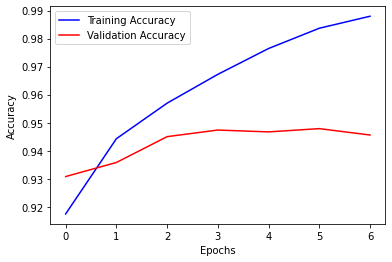

In [ ]:
# Plot the accuracy: 
# Set the grah:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Plot the training accuracy:
plt.plot(model.training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')
# Plot the test accuracy (validation):
plt.plot(model.training_history.history['val_accuracy'],
         label = 'Validation Accuracy',
         color = 'red')
# Set the legent:
plt.legend()
# Show:
plt.show()

Along with the loss metric values, we see that, based on the results on the validation dataset, that our model is actually overfitting.

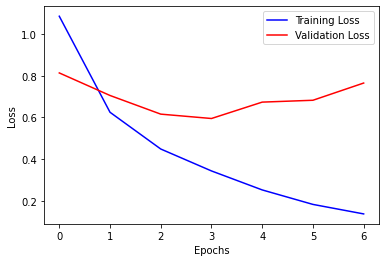

In [ ]:
# Set the grah:
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Plot the training accuracy:
plt.plot(model.training_history.history['loss'],
         label = 'Training Loss',
         color = 'blue')
# Plot the test accuracy (validation):
plt.plot(model.training_history.history['val_loss'],
         label = 'Validation Loss',
         color = 'red')
# Set the legent:
plt.legend()
# Show:
plt.show()

Since we have a multilabel classification model, it is detrimental to look further into the detailed results for each individual category/class rather than the overall results. 

Doing so, we can clearly see based on the precision, recall & f1-score values below that our model poorly identifies some classes (# 2, 6 & 7).

In [ ]:
# from tensorflow.keras.models import Model

y_pred_class = model.y_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       604
           1       0.97      0.99      0.98       621
           2       0.62      0.43      0.51       661
           3       0.96      0.81      0.88       631
           4       0.86      0.97      0.91       620
           5       0.98      0.98      0.98       629
           6       0.45      0.57      0.50       617
           7       0.48      0.46      0.47       552

    accuracy                           0.78      4935
   macro avg       0.77      0.77      0.77      4935
weighted avg       0.78      0.78      0.77      4935



Using a confusion matrix, we can also determine that though our model seems to do a better job at identifying the class #2 (hence the "better" precision when compared to the classes #6 & 7), it clearly struggles to discriminate both classes #6 & 7. 

Interestingly, these 3 classes (#2, 6 & 7) correspond to the larges classes of our dataset ('Diabetes', 'Normal', 'Others', respectively), which each represent 25 to 30% of our dataset. 

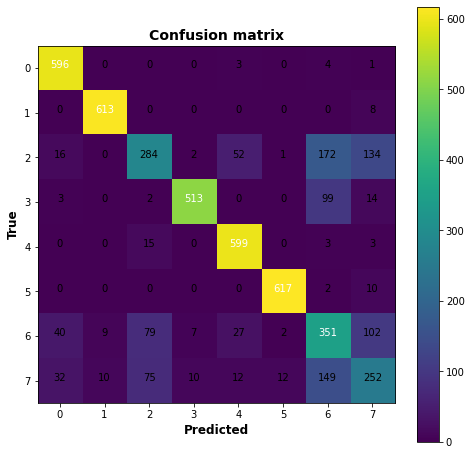

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#labels = ['AMD', 'Cataract', 'Diabetes', 'Glaucoma', 'Hypertension', 'Myopia', 'Normal', 'Others']

cm = confusion_matrix(y_test_class, y_pred_class)
cmd = ConfusionMatrixDisplay(cm, display_labels=True)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.title('Confusion matrix', fontweight="bold", fontsize=14)
cax = ax.matshow(cm)
fig.colorbar(cax)

plt.xlabel('Predicted', fontweight="bold", fontsize=12)
#ax.set_xticklabels([''] + labels, rotation = 90)
ax.xaxis.set_ticks_position('bottom')

plt.ylabel('True', fontweight="bold", fontsize=12)
#ax.set_yticklabels([''] + labels)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, cm[i, j],
           horizontalalignment="center",
           color="white" if cm[i, j] > ( cm.max() / 2) else "black")


#CONCLUSION:
The results presented above are consistent no matter which model we used or which adjustments we made. 

Indeed, the number of layers did not improve our models. And while the number of neurons improved the overall accuracy, it also increase the risk of reaching model overfitting. 

<b>Based on these results, the main issue to address at this stage to improve our model is the image processing. Indeed: </b>

- knowing that the datagenerator can only perform a limited number of operations, and given that it multiplied up to 12 times the number of eye-fundi originally assigned to some classes, the quantity of images generated using this method lead to a decrease in their diversity, hence a greater homogeneity of the less represented classes.
<br>This would imply that our model performs better at discriminating homogenous classes versus heterogenous ones.
<br><i>--> To address this issue, one solution could be to feed the less-represented classes with more patients' eye-fundi in order to increase the diversity of images while balancing the classes</i>.

- there are limitations due to the disparity or diseases adressed here. 
<br>While some seem easy to discriminate even by a non-expert (e.g. caratact, <i>see
TV1_ODIR19/III-Image_processing/</i>), others require to look at very specific areas of the fundus (e.g. glaucoma, characterized by modifications of a cup/disk (C/D) ratio in the region where the optic nerve and blood vessels go through the retina).
<br><i>--> This requires to process the images using image segmentation</i>.

- some eye-fundi have been assigned to a given disease even if only 'suspected' (<i>see README.md</i>). <br>This could mean that near-normal images are present in some classes and could generate some background "noise" in our classification.  <br><i>--> The weight of such images within the dataset <u> and within each class</u> has to be addressed prior and after the image processing as generating new images could also artificially changed the weight of such images within each class</i>.

<b>Thus, it seems detrimental to further work on the image processing step prior trying to further improve any classification model.
